Modelo de Vicsek con ruido extrínseco y variación de la densidad

In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from math import *
from tqdm import tqdm
import matplotlib.animation as animation
import grispy as gsp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parámetros del sistema y condiciones iniciales

In [35]:
N = 300 # Número de individuos
rho = np.linspace(0.01,10,40) # Densidad
L = np.sqrt(N/rho)

In [36]:
W = 0.05 # Ruido
r = 1 # Radio de cada individuo
dt = 1 # Paso de tiempo
tf = 200 # Duración simulación
t = np.linspace(0,tf,int(tf/dt)+1)
v = 0.3 # Velocidad absoluta de los individuos
theta_0 = np.random.uniform(-np.pi,np.pi,[N]) # Orientación inicial aleatoria de los individuos
eps = 1e-15 # para solucionar una cosa de las CC periódicas
print(L,N,rho,W,v)

[173.20508076  33.57331723  23.96610272  19.63098301  17.02829484
  15.2453123   13.92599607  12.89892447  12.07002356  11.3827987
  10.80100371  10.30017378   9.86311905   9.47736035   9.13358965
   8.82470392   8.54517605   8.29063199   8.05755888   7.8430986
   7.64489881   7.46100338   7.28977056   7.12981082   6.97993913
   6.83913786   6.70652751   6.58134353   6.46291768   6.35066299
   6.24406146   6.142654     6.04603206   5.95383073   5.86572288
   5.78141431   5.7006396    5.62315858   5.54875332   5.47722558] 300 [ 0.01        0.26615385  0.52230769  0.77846154  1.03461538  1.29076923
  1.54692308  1.80307692  2.05923077  2.31538462  2.57153846  2.82769231
  3.08384615  3.34        3.59615385  3.85230769  4.10846154  4.36461538
  4.62076923  4.87692308  5.13307692  5.38923077  5.64538462  5.90153846
  6.15769231  6.41384615  6.67        6.92615385  7.18230769  7.43846154
  7.69461538  7.95076923  8.20692308  8.46307692  8.71923077  8.97538462
  9.23153846  9.48769231  9.743

Implementación del modelo

In [37]:
p_c = np.zeros(np.size(L))

In [38]:
def angle(x,y):
    if x<0 and y<0: return np.arctan(y/x)-np.pi
    elif x<0 and y>0: return np.arctan(y/x)+np.pi
    else: return np.arctan(y/x)

In [39]:
for c in tqdm(range(np.size(L))):

    periodic = {0: (0, L[c]), 1: (0, L[c])}

    pos = np.zeros([N,3,np.size(t)]) # Matriz Nx3xsize(t)

    x_0 = np.random.uniform(0,L[c],[N])# Posiciones iniciales aleatorias de los individuos
    y_0 = np.random.uniform(0,L[c],[N])

    pos[:,0,0] = x_0
    pos[:,1,0] = y_0
    pos[:,2,0] = theta_0

    for i in range(np.size(t)-1):

        grid = gsp.GriSPy(pos[:,0:2,i], N_cells=N, periodic=periodic)

        # contar cuántos individuos están dentro del círculo unidad para cada uno y calcular las nuevas orientaciones
        
        for j in range(N):
            dtheta = np.random.uniform(-np.pi,np.pi)
            cont = 0

            bubble_dist, bubble_ind = grid.bubble_neighbors(np.reshape(pos[j,0:2,i],[1,2]), distance_upper_bound=r)

            cont = np.size(bubble_ind)
            b = pos[bubble_ind,2,i]
            pos[j,2,i+1] = angle((np.sum(np.cos(b))/cont)+W*np.cos(dtheta),(np.sum(np.sin(b))/cont)+W*np.sin(dtheta))
        
        # calcular las nuevas posiciones
            
        pos[:,0,i+1] = pos[:,0,i]+v*np.cos(pos[:,2,i+1])*dt
        pos[:,1,i+1] = pos[:,1,i]+v*np.sin(pos[:,2,i+1])*dt

        for j in range(N):
            if pos[j,0,i+1] >= L[c]:
                pos[j,0,i+1] = 0+eps
            if pos[j,0,i+1] <= 0:
                pos[j,0,i+1] = L[c]-eps
            if pos[j,1,i+1] >= L[c]:
                pos[j,1,i+1] = 0+eps
            if pos[j,1,i+1] <= 0:
                pos[j,1,i+1] = L[c]-eps

    # calcular el parámetro de control (momento promedio normalizado)
                
    p_c[c] = (1/tf)*scipy.integrate.simpson((1/(N*v))*np.sqrt(np.sum(v*np.cos(pos[:,2,:]),axis=0)**2+np.sum(v*np.sin(pos[:,2,:]),axis=0)**2),t)
    #p_c[c] = (1/(N*v*10))*np.sum(np.sqrt(np.sum(v*np.cos(pos[:,2,np.size(t)-11:np.size(t)-1]),axis=0)**2+np.sum(v*np.sin(pos[:,2,np.size(t)-11:np.size(t)-1]),axis=0)**2))

100%|██████████| 40/40 [10:56:17<00:00, 984.44s/it]   


Representación gráfica

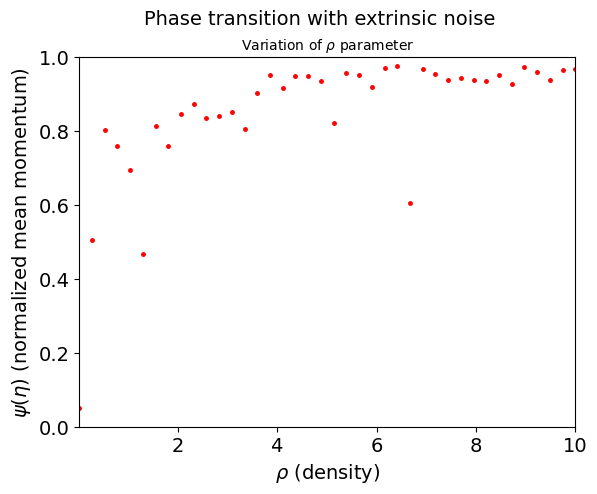

In [40]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.plot(rho,p_c,'.',color='red',markersize='5')
plt.xlim([min(rho),max(rho)])
plt.ylim([0,1])
plt.title(r'Variation of $\rho$ parameter',fontsize = 10)
plt.xlabel(r'$\rho$ (density)',fontsize = 14)
plt.ylabel('$\psi(\eta)$ (normalized mean momentum)',fontsize = 14)
plt.suptitle('Phase transition with extrinsic noise',fontsize = 14)
plt.savefig('extrinsic_var_rho.png')

Animación

In [41]:
def update_map(num,x,y,dx,dy):
    plt.cla()
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    plt.axis('tight')
    plt.quiver(x[num], y[num], dx[num], dy[num])
    plt.xlim([0,L[c]])
    plt.ylim([0,L[c]])
    plt.title('Evolution of collective dynamics' ,fontsize = 14)
    plt.xlabel('$X$',fontsize = 14)
    plt.ylabel('$Y$',fontsize = 14)
    plt.suptitle('t = '+str(format(num*dt,'.0f')))

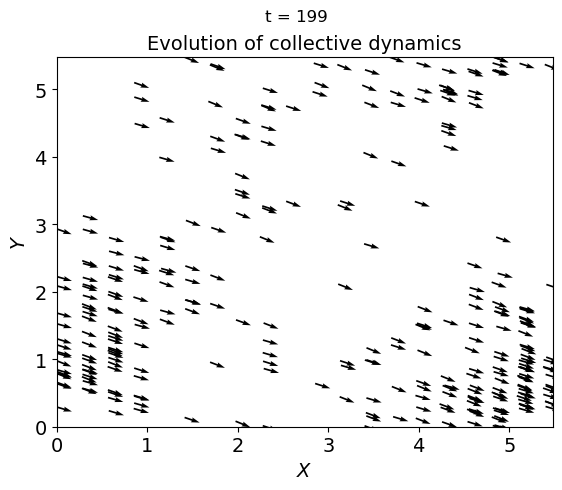

In [42]:
im1 = plt.figure()
fig1 = plt.quiver(pos[:,0,0],pos[:,1,0],v*np.cos(pos[:,2,0]),v*np.sin(pos[:,2,0]))

anim1 = animation.FuncAnimation(im1, update_map, np.size(t)-1, fargs = (np.transpose(pos[:,0,:]),np.transpose(pos[:,1,:]),np.transpose(v*np.cos(pos[:,2,:])),np.transpose(v*np.sin(pos[:,2,:]))), interval = 100)
anim1.save('FIGURA4.gif')
anim1.save('FIGURA4.mp4')